In [1]:
import os
import sys
import json
import openai
import codecs
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from openai import OpenAI
from datetime import datetime
from dotenv import load_dotenv
from dataReader import getLabels
from Mapper import saveOutput,runGPT,runGPTft,batchData,validateApiKey
from sklearn.model_selection import train_test_split

In [19]:
_,file_labels,_,targets,_,_,ontology,_ = getLabels()

In [10]:
load_dotenv()

setup_file = open('./Prompts/AssistantSetupFineTuning.txt', 'r')
assistant_prompt = ' '.join(setup_file.readlines()).replace('\n', '')

prompt_file = open('./Prompts/TaskPrompt.txt', 'r')
request_prompt = ' '.join(prompt_file.readlines()).replace('\n', '')

context_file = open('./test.txt', 'r')
context = context_file.read()

id_file = open('id_assistant_ft.txt', 'r')
assistant_id = id_file.read()

key = os.environ['OPENAI_API_KEY']

mapping = getLabels()
batches = batchData(mapping[0])
messages = []
assistant_prompt = assistant_prompt.replace('@', '').replace('$',context)
request_prompt = request_prompt.replace('*', context)
'''
if validateApiKey(key):
    print(f'Given key: {key[:3] }...{ key[-4:]}')
            
    for i in tqdm(range(0,len(batches),1)):
        messages.append(runGPTft(assistant_id, assistant_prompt ,request_prompt, key, batches=batches[i:i+1], few_shot=True))

'''

"\nif validateApiKey(key):\n    print(f'Given key: {key[:3] }...{ key[-4:]}')\n            \n    for i in tqdm(range(0,len(batches),1)):\n        messages.append(runGPTft(assistant_id, assistant_prompt ,request_prompt, key, batches=batches[i:i+1], few_shot=True))\n\n"

In [10]:
context

'Ontology 1, EnershareForecast:\n@prefix owl: <http://www.w3.org/2002/07/owl#> .\n@prefix dc: <http://purl.org/dc/terms/> .\n@prefix foaf: <http://xmlns.com/foaf/0.1/> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n@prefix ns0: <http://purl.org/vocab/vann/> .\n@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n@prefix ns1: <http://www.w3.org/2003/06/sw-vocab-status/ns#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\n<http://purl.org/vocommons/voaf#Vocabulary> a owl:Class .\ndc:title a owl:AnnotationProperty .\ndc:description a owl:AnnotationProperty .\ndc:issued a owl:AnnotationProperty .\ndc:modified a owl:AnnotationProperty .\ndc:creator a owl:AnnotationProperty .\ndc:contributor a owl:AnnotationProperty .\ndc:license a owl:AnnotationProperty .\n<http://purl.org/vocab/vann/preferredNamespacePrefix> a owl:AnnotationProperty .\n<http://purl.org/vocab/vann/preferredNamespaceUri> a owl:AnnotationProperty .\n<http://www.w3.org/2003/06/sw-vocab-status/ns#term_st

In [26]:
messages[0][0].choices[0].message.content

'{Label: GearOilTemperature_val, Match: Temperature Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: GearboxOilInletTemperature_val, Match: Temperature Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: GearboxOilInletPressure_val, Match: Pressure Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: HssGearBearingGenSideTemperature_val, Match: Temperature Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: GearboxRotationSpeed_val, Match: Rotational Speed Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: GearboxOilPumpPressure_val, Match: Pressure Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: DeltaOilTemperature, Match: Temperature Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: RatioOilGearTemperature, Match: Temperature Property, Ontology: SEASGenericProperty, Score: 1}\n{Label: Time [s], Match: Time Instant, Ontology: Time, Score: 1}\n{Label: Nacelle_Anemometer [m/s], Match: Wind Speed Property, Ontology: SEASGen

In [3]:
saveOutput(messages, './Results/outputGPT3.5_ft_test.txt', True)

In [11]:
#file = open('./Prompts/AssistantSetupFineTuning.txt', 'r')
#assistant_prompt = file.read()
file2 = open('./Prompts/TaskPrompt.txt')
task_prompt = file2.read()
task_prompt = task_prompt.replace('@', '')

In [12]:
data = [{"messages": [{"role" : "system", "content": assistant_prompt}, {"role" : "user", "content" : task_prompt.replace('$', x)}, {"role" : "assistant", "content" : f"{{Label: {x}, Match: {y}, Ontology: {z}, Score: {1}}}"}]} for x,y,z in zip(file_labels,targets,ontology)]
train,test = train_test_split(data,train_size=50)

with open('train_data2.jsonl', 'w') as f:
    for i in train:
        json.dump(i, f)
        f.write('\n')
f.close()

with open('test_data2.jsonl', 'w') as f:
    for i in test:
        json.dump(i, f)
        f.write('\n')
f.close()

In [2]:
def castMatrix(data, dtype=int):
    return list(map(lambda sub: list(map(dtype, sub)), data))

In [3]:
f = open('./Results/accuracies.txt', 'r')
res = f.readlines()
res = [x.strip().split() for x in res if x[0] != '#']
res = castMatrix(res, float)

In [7]:
res

[[0.208, 0.187, 0.196, 0.2, 0.199, 0.189, 0.179, 0.193, 0.188],
 [0.244, 0.204, 0.212, 0.235, 0.238, 0.22, 0.199, 0.204, 0.201],
 [0.199, 0.191, 0.189, 0.202, 0.194, 0.199, 0.187, 0.201, 0.195, 0.194],
 [0.236, 0.216, 0.218, 0.31, 0.228, 0.215, 0.222, 0.213, 0.241, 0.23],
 [0.226, 0.221, 0.236, 0.221, 0.224, 0.231, 0.228, 0.211, 0.22],
 [0.231, 0.229, 0.237, 0.246, 0.231, 0.234, 0.231, 0.246, 0.233],
 [0.157, 0.191, 0.198, 0.172, 0.182, 0.167, 0.179, 0.193, 0.189],
 [0.183, 0.232, 0.246, 0.21, 0.214, 0.199, 0.208, 0.223, 0.218],
 [0.184, 0.187, 0.185, 0.171, 0.178, 0.207, 0.195, 0.185, 0.188],
 [0.257, 0.261, 0.253, 0.262, 0.272, 0.291, 0.256, 0.272, 0.254],
 [0.221, 0.2, 0.214, 0.186, 0.206, 0.202, 0.169, 0.192, 0.188],
 [0.306, 0.27, 0.286, 0.258, 0.261, 0.282, 0.228, 0.256, 0.253],
 [0.233, 0.233, 0.228, 0.232],
 [0.345, 0.329, 0.336, 0.322]]

In [4]:
def variance(data: list):
    #data = [x*100 for x in data]
    mean = sum(data)/len(data)
    counter = sum([(x - mean)**2 for x in data])

    print(f'Mean: {round(mean,3)} \nVariance: {round(counter/(len(data)-1), 7)}')

In [6]:
models = ['GPT3.5 zero-shot', 'GPT3.5 few-shot', 'GPT3.5 Fine-Tuned', 'GPT3.5 IEC context', 'GPT4 zero-shot', 'GPT4 few-shot']
for i,x in enumerate(res):
    variance(x)


Mean: 0.193 
Variance: 7.39e-05
Mean: 0.217 
Variance: 0.0003055
Mean: 0.195 
Variance: 2.61e-05
Mean: 0.233 
Variance: 0.0008217
Mean: 0.224 
Variance: 5.19e-05
Mean: 0.235 
Variance: 4.17e-05
Mean: 0.181 
Variance: 0.0001819
Mean: 0.215 
Variance: 0.0003347
Mean: 0.187 
Variance: 0.0001022
Mean: 0.264 
Variance: 0.0001504
Mean: 0.198 
Variance: 0.0002485
Mean: 0.267 
Variance: 0.0005087
Mean: 0.232 
Variance: 5.7e-06
Mean: 0.333 
Variance: 9.67e-05


In [2]:
from test import labelDict,labelDictAlt
import re

In [40]:
_,true_labels,true_paths,true_matches,_,true_sources,true_ontologies,_ = getLabels(path='mapping.xlsx')
dictionary = labelDict(zip(true_labels,true_matches,true_ontologies))
dictionary2 = labelDict(zip(true_labels,true_paths,true_ontologies))
dictalt = labelDictAlt(zip(true_labels,true_matches,true_ontologies))
dictalt2 = labelDictAlt(zip(true_labels,true_paths,true_ontologies))


f = open('./Results/outputGPT3.5_ft.txt','r', encoding='utf-8')
lines = f.readlines()
print(len(lines))
lines = [x for x in lines if x != '\n']
print(len(lines))

pred_labels = []
pred_matches = []
pred_sources = []
scores = []
for l in lines:
    if re.search('{.*}', l) != None:
        try:
            pred_labels.append(re.search('Label:(.*)Match:', l).group(1)[1:-2].strip().lower())
            pred_matches.append(re.search('Match:(.*)Ontology:', l).group(1)[1:-2].lower())
            pred_sources.append(re.search('Ontology:(.*)Score:', l).group(1)[1:-2].lower().replace('.txt', ''))
            scores.append(float(re.search('Score:(.*)}', l).group(1).strip()))
        except Warning:
            print('Something went wrong')

#pred_matches = [y.replace('<', '').replace('>', '') for y in ['noMatch' if x[0] != '<' else x for x in pred_matches]]

predictions = list(zip(pred_labels,pred_matches,pred_sources))

562
562


In [41]:
scores = [x for x in scores if x != 0]
print(sum(scores)/len(scores))
vier_zs = [0.46158536585365884, 0.835804416403786]
vier_fs = [0.5290940766550518, 0.8777456647398837]
drievijf_zs = [0.17552447552447523, 0.6924137931034471]
drievijf_fs = [0.466370106761566, 0.970740740740741]
drievijf_ec = [0.3182300884955752, 0.9988888888888889]

1.0


In [10]:
predictions[130:150]

[('thermal power(kw)', 'thermal energy property', 'enersharesystem'),
 ('upra_gji_id', 'nomatch', 'nomatch'),
 ('zk_gji_id', 'nomatch', 'nomatch'),
 ('to_cev_name', 'nomatch', 'nomatch'),
 ('diameter_nominal_mm', 'nomatch', 'nomatch'),
 ('external_diameter_mm', 'nomatch', 'nomatch'),
 ('year_of_construction', 'nomatch', 'nomatch'),
 ('year_of_insulation', 'nomatch', 'nomatch'),
 ('branch', 'nomatch', 'nomatch'),
 ('type_of_grid_name', 'nomatch', 'nomatch'),
 ('functionname', 'nomatch', 'nomatch'),
 ('material_type', 'materialproperty', 'enershareproperty'),
 ('owner_name', 'nomatch', 'nomatch'),
 ('manager_name', 'nomatch', 'nomatch'),
 ('system_name', 'nomatch', 'nomatch'),
 ('source_name', 'nomatch', 'nomatch'),
 ('accuracy_xy_name', 'nomatch', 'nomatch'),
 ('accuracy_z_name', 'nomatch', 'nomatch'),
 ('gji_vis_date_name', 'nomatch', 'nomatch'),
 ('gji_zk_id', 'nomatch', 'nomatch')]

In [10]:
dictionary2['stn']

[('nomatch', 'nomatch.txt')]

In [18]:
'outputGPTsomethingsomething'[6:]

'GPTsomethingsomething'

In [26]:
t = "FN: (0, gearoiltemperature_val, nomatch)"
try: 
    d = [x.strip() for x in re.search('\(.*\)', t).group(0)[1:-1].split(",")[1:]]
except:
    d =''

d

['gearoiltemperature_val', 'nomatch']

In [28]:
i = d

if i:
    print('l')

l


In [30]:
name = 'predictions_GPT3.5.txt'
path = 'predictions_GPT'

name[:len(path)]

'predictions_GPT'

In [1]:
'nomatch'.split()

['nomatch']

In [1]:
from Analysis import *
import matplotlib.pyplot as plt

['predictions_GPT3.5.txt', 'predictions_GPT3.5_Comment.txt', 'predictions_GPT3.5_ec.txt', 'predictions_GPT3.5_fewshot.txt', 'predictions_GPT3.5_ft.txt', 'predictions_GPT3.5_ft2.txt', 'predictions_GPT3.5_ft_test.txt', 'predictions_GPT3.5_ft_vs.txt', 'predictions_GPT3.5_ft_vs2.txt', 'predictions_GPT3.5_sv.txt', 'predictions_GPT3.5_test.txt', 'predictions_GPT3.5_URI.txt', 'predictions_GPT3.5_zeroshot.txt', 'predictions_GPT4.txt', 'predictions_GPT4_zeroshot.txt']
['predictions_GPT3.5.txt', 'predictions_GPT3.5_ec.txt', 'predictions_GPT3.5_fewshot.txt', 'predictions_GPT3.5_ft.txt', 'predictions_GPT3.5_ft2.txt', 'predictions_GPT3.5_ft_test.txt', 'predictions_GPT3.5_ft_vs.txt', 'predictions_GPT3.5_ft_vs2.txt', 'predictions_GPT3.5_sv.txt', 'predictions_GPT3.5_test.txt', 'predictions_GPT3.5_zeroshot.txt', 'predictions_GPT4.txt', 'predictions_GPT4_zeroshot.txt']
13


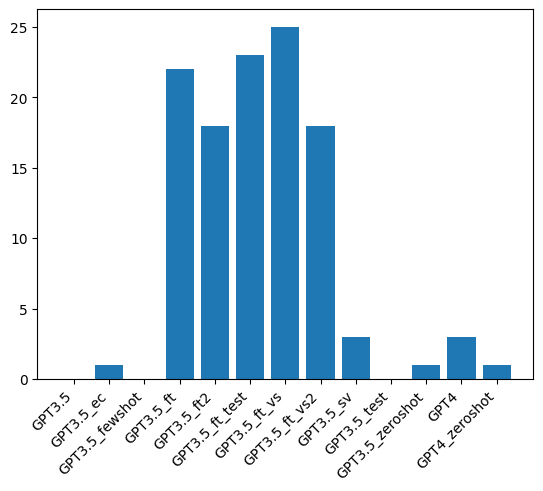

In [2]:
path = 'predictions_GPT'
files = getFiles(path)
print(files)
files,correct_per_file = getCorrectPredictions(files)
print(files)
print(len(correct_per_file))
N = correct_per_file[0]
for c in correct_per_file[1:]:
    N = intersection(N,c)

#print(removeList(correct_per_file[0], N))

data = []
complements = relativeComplements(correct_per_file)
for f,c in zip(files,complements):
    for x in c:
        data.append((x[0],x[1],f))

df = pd.DataFrame(data=data, columns=['Label', 'Match', 'Model'])

data_count= [(len(df[df['Model'] == x]),x[12:-4]) if x in set(list(df['Model'])) else (0,x[12:-4]) for x in files]
#print(data_count)
dfcount = pd.DataFrame(data=data_count, columns=['#Label', 'Model'])

fig, ax = plt.subplots()

ax.bar(dfcount['Model'], dfcount['#Label'])
plt.xticks(rotation=45,ha='right')

plt.show()

kijk naar vorm, ontologië wel goed voorspeld, ... 


In [3]:
t = ['hello world', 'hoi']
'\n'.join(t)

'hello world\nhoi'

In [16]:
from scipy.stats import ttest_rel,f_oneway

In [6]:
models = ["GPT3.5_zero","GPT3.5_few","GPT3.5_ft","GPT3.5_IEC","GPT4_zero", "GPT4_few"]

In [9]:
normal = res[0::2]
path = res[1::2]
path

[[0.244, 0.204, 0.212, 0.235, 0.238, 0.22, 0.199, 0.204, 0.201],
 [0.236, 0.216, 0.218, 0.31, 0.228, 0.215, 0.222, 0.213, 0.241],
 [0.231, 0.229, 0.237, 0.246, 0.231, 0.234, 0.231, 0.246, 0.233],
 [0.183, 0.232, 0.246, 0.21, 0.214, 0.199, 0.208, 0.223, 0.218],
 [0.257, 0.261, 0.253, 0.262, 0.272, 0.291, 0.256, 0.272, 0.254],
 [0.306, 0.27, 0.286, 0.258, 0.261, 0.282, 0.228, 0.256, 0.253]]

In [14]:
for i,m in zip(path,models):
    print()
    for j,n in zip(path,models):
        print(m,n)
        print(ttest_rel(i,j))


GPT3.5_zero GPT3.5_zero
TtestResult(statistic=nan, pvalue=nan, df=8)
GPT3.5_zero GPT3.5_few
TtestResult(statistic=-1.7336421141278775, pvalue=0.1212096235085881, df=8)
GPT3.5_zero GPT3.5_ft
TtestResult(statistic=-2.912149563915089, pvalue=0.01952468268144157, df=8)
GPT3.5_zero GPT3.5_IEC
TtestResult(statistic=0.25345789273112745, pvalue=0.8063064023003419, df=8)
GPT3.5_zero GPT4_zero
TtestResult(statistic=-7.230465088523508, pvalue=8.974343331334648e-05, df=8)
GPT3.5_zero GPT4_few
TtestResult(statistic=-7.598225407600674, pvalue=6.31545317771335e-05, df=8)

GPT3.5_few GPT3.5_zero
TtestResult(statistic=1.7336421141278775, pvalue=0.1212096235085881, df=8)
GPT3.5_few GPT3.5_few
TtestResult(statistic=nan, pvalue=nan, df=8)
GPT3.5_few GPT3.5_ft
TtestResult(statistic=-0.2272273770972429, pvalue=0.8259461742933654, df=8)
GPT3.5_few GPT3.5_IEC
TtestResult(statistic=1.4248927038626606, pvalue=0.19201020114400982, df=8)
GPT3.5_few GPT4_zero
TtestResult(statistic=-2.64850873892196, pvalue=0.0293

In [19]:
print(f_oneway(normal[0],normal[1],normal[2],normal[3],normal[4],normal[5]))
print(f_oneway(path[0],path[1],path[2],path[3],path[4],path[5]))

F_onewayResult(statistic=17.622489700298907, pvalue=7.026900800759027e-10)
F_onewayResult(statistic=11.918564225867001, pvalue=1.5944540022202645e-07)


In [1]:
from Analysis import getFiles

In [3]:
path = 'predictions_path_GPT'
files = getFiles(path)
stats = []

for file in files:
    tp, tn, fp, fn = 0,0,0,0

    f = open(f"./Analysis/{file}", "r", encoding="utf-8")
    lines = f.readlines()

    for l in lines:
        if l[:2] == 'TP':
            tp += 1
        elif l[:2] == 'TN':
            tn += 1
        elif l[:2] == 'FP':
            fp += 1
        elif l[:2] == 'FN':
            fn += 1
    
    try:
        precision = tp / (tp + fp)
    except:
        precision = 0
    try:
        recall = tp / (tp + fn)
    except:
        recall = 0
    try:
        f1 = (2 * tp)/(2*tp + fp + fn)
    except:
        f1 =0

    print(file)
    print(f"Precision: {round(precision,3)}, recall: {round(recall,3)}, f1; {round(f1,3)}")


predictions_path_GPT3.5.txt
Precision: 0.146, recall: 0.072, f1; 0.096
predictions_path_GPT3.5_Comment.txt
Precision: 0, recall: 0, f1; 0
predictions_path_GPT3.5_ec.txt
Precision: 0.221, recall: 0.097, f1; 0.135
predictions_path_GPT3.5_fewshot.txt
Precision: 0.038, recall: 0.024, f1; 0.029
predictions_path_GPT3.5_ft.txt
Precision: 0.144, recall: 0.561, f1; 0.229
predictions_path_GPT3.5_ft_vs.txt
Precision: 0.163, recall: 0.558, f1; 0.253
predictions_path_GPT3.5_sv.txt
Precision: 0.17, recall: 0.079, f1; 0.108
predictions_path_GPT3.5_zeroshot.txt
Precision: 0.138, recall: 0.059, f1; 0.083
predictions_path_GPT4.txt
Precision: 0.133, recall: 0.243, f1; 0.172
predictions_path_GPT4_zeroshot.txt
Precision: 0.192, recall: 0.259, f1; 0.22
